In [1]:
# !pip install -U segmentation-models-pytorch albumentations --user
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.models.segmentation
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import Dataset, DataLoader
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

In [3]:
import segmentation_models_pytorch as smp
import os
import pandas as pd
import random
import json
import math
from data import get_data
from tqdm import tqdm
from torchvision.io import read_image
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import torch.optim as optim
import pickle
from IPython.display import clear_output

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
data = get_data()

In [7]:
def downsample_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    f = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [8]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    return x

In [9]:
# https://stackoverflow.com/a/49290815
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [11]:
inputs = layers.Input(shape=(128,128,3))
f1, p1 = downsample_block(inputs, 16)
f2, p2 = downsample_block(p1, 32)
x = layers.Conv2D(64, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(p2)
x = layers.Dropout(0.3)(x)
u2 = upsample_block(x, f2, 32)
u1 = upsample_block(u2, f1, 16)
outputs = layers.Conv2D(1, 3, padding = "same", activation = "sigmoid", kernel_initializer = "he_normal")(u1)
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")


In [12]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d_5[0][0]']               
                                )                                                             

In [13]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=["accuracy", jaccard_distance])

In [14]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, draft_data, sz, batch_size=16, dim=(128,128), n_channels=3,
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.draft = draft_data
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.len = sz
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.len / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.len)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            elem = self.draft[ID]
            # Store sample
            X[i,] = elem[0]

            # Store class
            y[i] = elem[1]

        return X, y

In [15]:
def create_data(sz):
    X = []
    y = []
    for i in range(sz):
        elem = data[i]
        X.append(elem[0])
        y.append(elem[1])
    res = tf.data.Dataset.from_tensors((X, y))
    del X
    del y
    return res
    
train = DataGenerator(data, 5000)
val = DataGenerator(data, 64)
# del data

In [16]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.TensorBoard()
]

In [22]:
model_history = unet_model.fit(train,
                               verbose=2,
                               epochs=100,
                               validation_data=val                                )

Epoch 1/100
312/312 - 66s - loss: 0.1373 - accuracy: 0.9478 - jaccard_distance: 35.4549 - val_loss: 0.1159 - val_accuracy: 0.9539 - val_jaccard_distance: 35.4279 - 66s/epoch - 212ms/step
Epoch 2/100
312/312 - 66s - loss: 0.1436 - accuracy: 0.9460 - jaccard_distance: 35.8009 - val_loss: 0.1311 - val_accuracy: 0.9549 - val_jaccard_distance: 31.4095 - 66s/epoch - 212ms/step
Epoch 3/100


KeyboardInterrupt: 

1/1 [==============================] - 0s 22ms/step


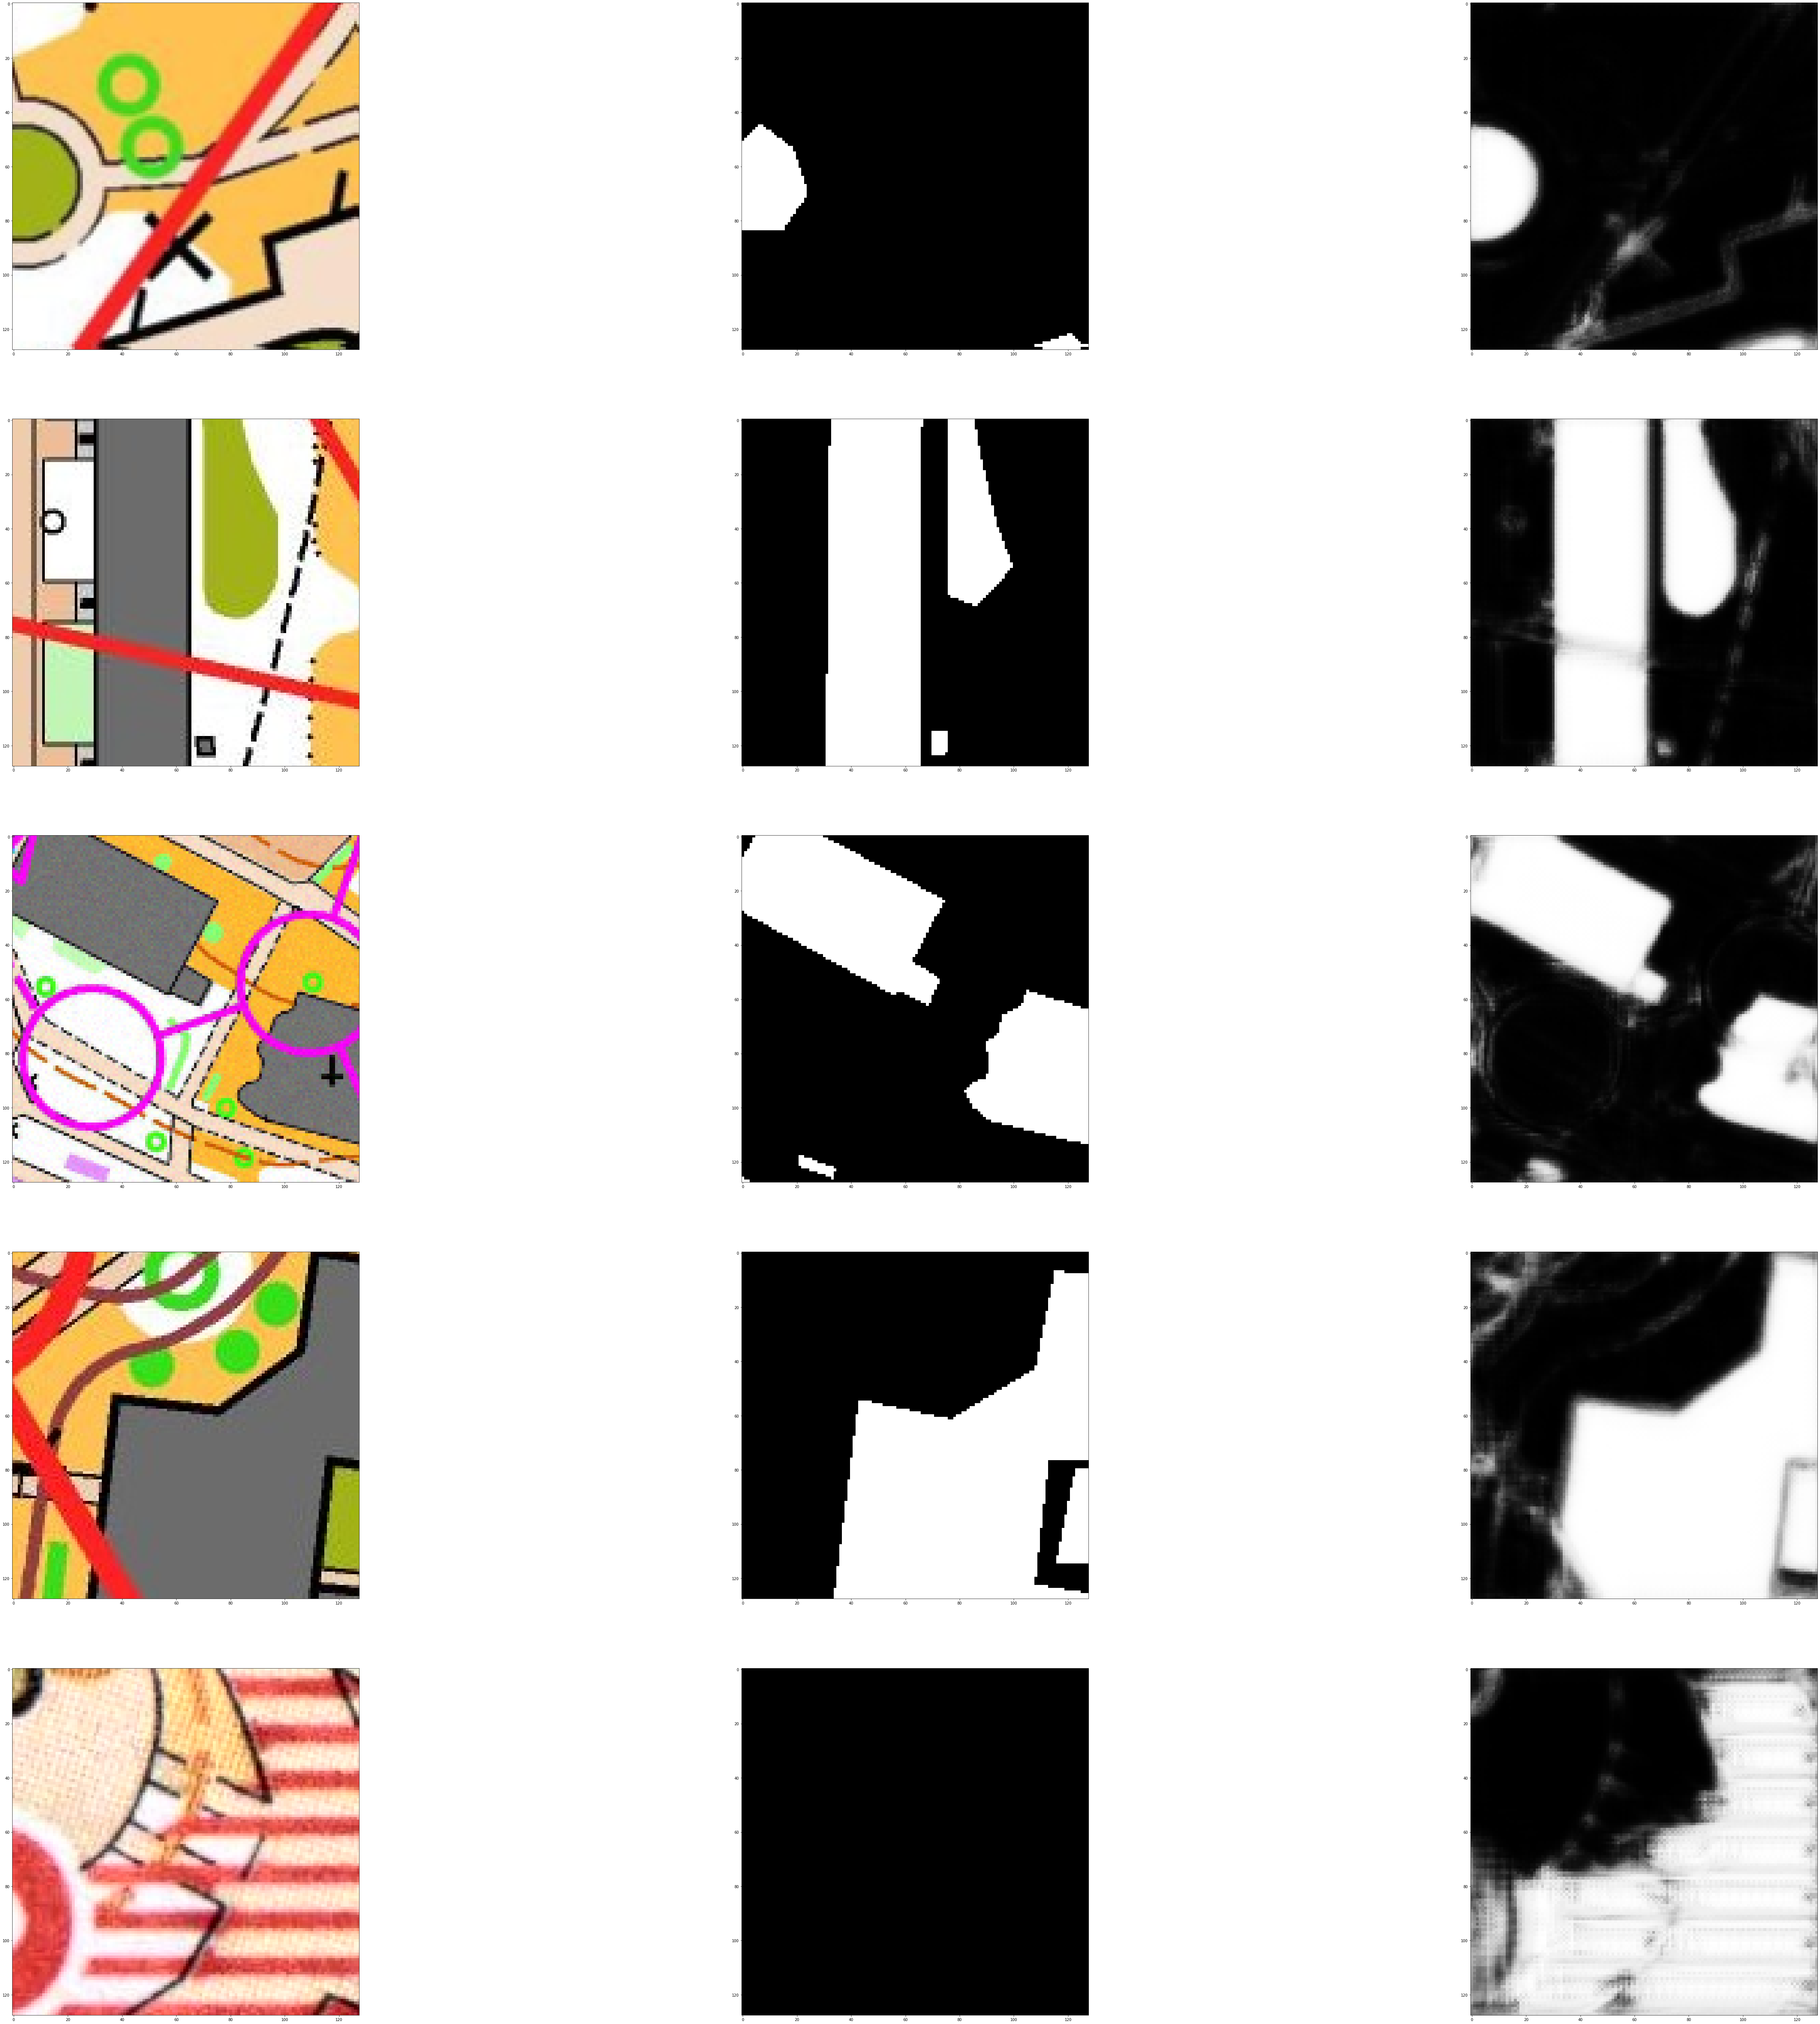

In [27]:
fig = plt.figure(figsize=(100, 100))
for i in range(5):
    X, y = val[0]#     X = X.permute(1, 2, 0).numpy()
    X = X[i]
    y = y[i]
    pred = unet_model.predict(np.array([X]))
    fig.add_subplot(5, 3, 3 * i + 1)
    plt.imshow(X)
    fig.add_subplot(5, 3, 3 * i + 2)
    plt.imshow(y, cmap='gray')
    fig.add_subplot(5, 3, 3 * i + 3)
    plt.imshow(pred[0], cmap='gray')
plt.show()

In [24]:
unet_model.save_weights('./checkpoints/my_checkpoint_1')